# Project 3, Reddit Upvote Data

This dataset contains testing and training sets for predicting the number of upvotes a post will receive on Reddit. The data includes factors such as the subreddit to which the post was submitted, post engagement in terms of the number of times the post was viewed or commented on, and the "reputation" of the post's author (which is a summative score of the performance of previous posts from a particular user.)

## Precursory setup

First, we'll import our tools and read our data.

In [1]:
# Import packages
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from statistics import mean

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Obtain datasets

df_test = pd.read_csv('upvote-dataset/test.csv')
df_train = pd.read_csv('upvote-dataset/train.csv')

In [3]:
# Check head

display(df_test.head(), df_train.head())

,ID,Tag,Reputation,Answers,Username,Views
0,366953,a,5645.0,3.0,50652,33200.0
1,71864,c,24511.0,6.0,37685,2730.0
2,141692,i,927.0,1.0,135293,21167.0
3,316833,i,21.0,6.0,166998,18528.0
4,440445,i,4475.0,10.0,53504,57240.0


,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [4]:
# View column data

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [5]:
# Verify that no null values exist

df_train.isnull().nunique()

ID            1
Tag           1
Reputation    1
Answers       1
Username      1
Views         1
Upvotes       1
dtype: int64

## Initial Exploration

Now that our data is read and we've verified its completeness, we can do some basic exploration of our variables.

a    31695
c    72458
h    20564
i    32400
j    72232
o    14546
p    43407
r    12442
s    23323
x     6978
Name: Tag, dtype: int64

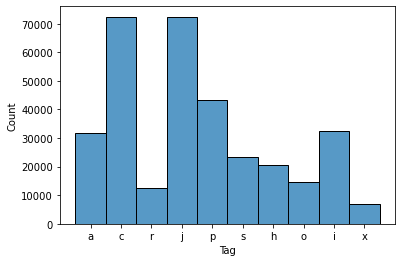

In [6]:
# View distribution of subreddits

sns.histplot(df_train.Tag)
df_train.Tag.value_counts().sort_index()

,ID,Reputation,Answers,Username,Views,Upvotes
ID,1.000000,0.010606,0.021396,0.000714,0.031908,0.029755
Reputation,0.010606,1.000000,0.191548,-0.117998,0.182435,0.660989
Answers,0.021396,0.191548,1.000000,-0.010498,0.553030,0.445785
Username,0.000714,-0.117998,-0.010498,1.000000,0.003269,-0.060878
Views,0.031908,0.182435,0.553030,0.003269,1.000000,0.664766
Upvotes,0.029755,0.660989,0.445785,-0.060878,0.664766,1.000000


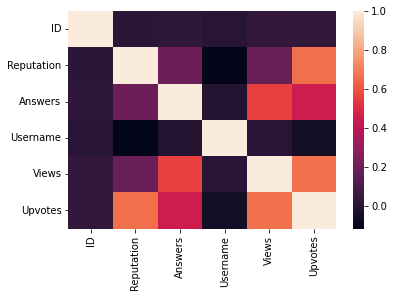

In [7]:
# View correlation matrix

sns.heatmap(df_train.corr(method='spearman'))
df_train.corr(method='spearman')

We initially see fairly strong correlation between upvotes and a user's prior reputation, along with post engagement. However, because our subreddit variable is nominal, we'll need to explore any correlation differently.

In [8]:
subreddit_dummies = pd.get_dummies(df_train.Tag)
df_train[['Upvotes']].join(subreddit_dummies).corr(method='spearman')

,Upvotes,a,c,h,i,j,o,p,r,s,x
Upvotes,1.000000,0.040728,0.039207,-0.037511,-0.055080,0.110071,-0.055706,0.016155,-0.093296,-0.066782,-0.051624
a,0.040728,1.000000,-0.172868,-0.084017,-0.107536,-0.172522,-0.069985,-0.126837,-0.064511,-0.089878,-0.047902
c,0.039207,-0.172868,1.000000,-0.136716,-0.174986,-0.280733,-0.113882,-0.206393,-0.104975,-0.146252,-0.077947
h,-0.037511,-0.084017,-0.136716,1.000000,-0.085047,-0.136442,-0.055349,-0.100311,-0.051020,-0.071081,-0.037884
i,-0.055080,-0.107536,-0.174986,-0.085047,1.000000,-0.174637,-0.070843,-0.128391,-0.065302,-0.090979,-0.048489
j,0.110071,-0.172522,-0.280733,-0.136442,-0.174637,1.000000,-0.113654,-0.205980,-0.104765,-0.145959,-0.077791
o,-0.055706,-0.069985,-0.113882,-0.055349,-0.070843,-0.113654,1.000000,-0.083558,-0.042499,-0.059210,-0.031557
p,0.016155,-0.126837,-0.206393,-0.100311,-0.128391,-0.205980,-0.083558,1.000000,-0.077022,-0.107308,-0.057192
r,-0.093296,-0.064511,-0.104975,-0.051020,-0.065302,-0.104765,-0.042499,-0.077022,1.000000,-0.054579,-0.029089
s,-0.066782,-0.089878,-0.146252,-0.071081,-0.090979,-0.145959,-0.059210,-0.107308,-0.054579,1.000000,-0.040526


From the correlation table above, we do see slight differences in correlation between upvotes between subreddits, but nothing particularly large.

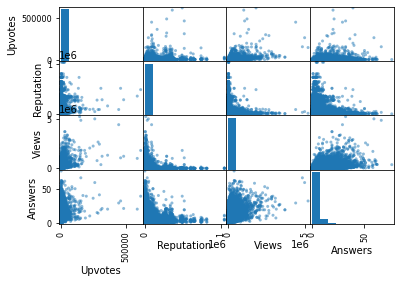

In [9]:
# View scatter matrix of correlated attributes

scatter_matrix(df_train[['Upvotes', 'Reputation', 'Views', 'Answers']])
pass

## One-Hot Encoding

We can quantify the categorical subreddit variable using a one-hot encoder. Because this attribute isn't ordinal in any way, we wouldn't use an ordinal encoder for this exploration.

In [10]:
# Demonstrate one-hot encoding for subreddit attribute

subreddit_encoder = OneHotEncoder()
subreddit_ohe_train = subreddit_encoder.fit_transform(pd.DataFrame(df_train.Tag))
subreddit_ohe_test = subreddit_encoder.fit_transform(pd.DataFrame(df_test.Tag))

In [11]:
subreddit_ohe_train.toarray()[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Custom Transformer

Next, we'll define some custom transformers to better quantify engagement. In our case, it's probably important to understand the "conversion rate" of upvotes and comments in terms of how many times a post is viewed. By understanding the engagement in terms of comments per view, we hope to better predict how this engagement translates to upvote rate.

In [12]:
# Define index constants
reputation_index, comments_index, views_index = 2, 3, 5

In [13]:
# Define transformer class
class EngagementTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reputation_index, self.comments_index, self.views_index = reputation_index, comments_index, views_index
        pass
    def fit(self, *args, **kwargs):
        return self
    def transform(self, data):
        # Convert to np array from pandas dataframe
        if type(data) == pd.core.frame.DataFrame:
            data = data.to_numpy()

        # Redefine column indexes if necessary
        if data.shape[1] == 3:
            self.reputation_index, self.comments_index, self.views_index = 0, 1, 2

        # Define user karma * post views engagement stat
        karma_view_prod = data[:, self.reputation_index] * data[:, self.views_index]

        # Define comments per view engagement stat
        comments_per_view = data[:, self.comments_index] / data[:, self.views_index]

        return np.c_[data, karma_view_prod, comments_per_view]

# Transform datasets and obtain columns for new engagement attributes
train_transformer = EngagementTransformer()
train_engagement_cols = train_transformer.transform(df_train.values)[:, [7, 8]]

test_transformer = EngagementTransformer()
test_engagement_cols = test_transformer.transform(df_test.values)[:, [6, 7]]

train_engagement_cols[:10]

array([[30964410.0, 0.0002546148949713558],
       [1453392846.0, 0.00021504990949982976],
       [10954986.0, 0.0004958472790380563],
       [7144896.0, 0.00011084835944428023],
       [59734206.0, 0.000286000286000286],
       [2453880.0, 0.00017930787161556393],
       [2526048.0, 5.819366852886406e-05],
       [707928.0, 0.00641025641025641],
       [5964918.0, 3.721761137370204e-05],
       [624023.0, 0.004405286343612335]], dtype=object)

In [14]:
# Define new transformed datasets
df_train_trnsf = df_train.join(pd.Series(train_engagement_cols[:, 0], name='karma_view_prod').astype(float))
df_test_trnsf = df_test.join(pd.Series(test_engagement_cols[:, 0], name='karma_view_prod').astype(float))

df_train_trnsf = df_train_trnsf.join(pd.Series(train_engagement_cols[:, 1], name='comments_per_view').astype(float))
df_test_trnsf = df_test_trnsf.join(pd.Series(test_engagement_cols[:, 1], name='comments_per_view').astype(float))

df_train_trnsf.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,karma_view_prod,comments_per_view
0,52664,a,3942.0,2.0,155623,7855.0,42.0,3.096441e+07,0.000255
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,1.453393e+09,0.000215
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1.095499e+07,0.000496
3,96996,a,264.0,3.0,168793,27064.0,9.0,7.144896e+06,0.000111
4,131465,c,4271.0,4.0,112223,13986.0,83.0,5.973421e+07,0.000286


,Upvotes,karma_view_prod
Upvotes,1.000000,0.873497
karma_view_prod,0.873497,1.000000


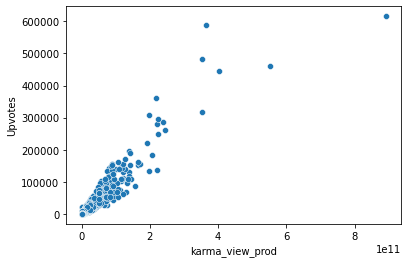

In [15]:
# Explore relationship between combined attribute and upvotes on the training set

sns.scatterplot(x=df_train_trnsf.karma_view_prod, y=df_train_trnsf.Upvotes)
df_train_trnsf[['Upvotes', 'karma_view_prod']].corr(method='spearman')

Great! With our transformed attribute measuring engagement and user reputation, we obtain a fairly improved correlation.

## Numerical Scaling using `sklearn.preprocessing`

Next, we'll scale our numerical attributes. This will allow our model to better interpret differences in values without the need to understand the magnitude of each variable.

In [16]:
# Define scaler instance and define scaled dataframes

scaler = StandardScaler()
col_names = ['Reputation', 'Answers', 'Views', 'karma_view_prod', 'comments_per_view']

df_train_sc = pd.DataFrame(scaler.fit_transform(df_train_trnsf[col_names]))
df_test_sc = pd.DataFrame(scaler.fit_transform(df_test_trnsf[col_names]))

df_train_sc.columns = col_names
df_test_sc.columns = col_names

df_train_sc[:10]

,Reputation,Answers,Views,karma_view_prod,comments_per_view
0,-0.141573,-0.535736,-0.269158,-0.080277,-0.259441
1,0.675238,2.257943,0.323087,0.328507,-0.268042
2,-0.237059,0.023000,-0.266540,-0.086028,-0.206997
3,-0.277486,-0.256368,-0.031882,-0.087123,-0.290695
4,-0.129415,0.023000,-0.193426,-0.072009,-0.252617
5,-0.270982,-0.815104,-0.297297,-0.088471,-0.275812
6,-0.281809,-0.815104,-0.153923,-0.088450,-0.302142
7,-0.203395,-0.535736,-0.362332,-0.088973,1.078793
8,-0.283140,-0.535736,0.297604,-0.087462,-0.306703
9,-0.185658,-0.815104,-0.363382,-0.088997,0.642914


## Combining Transformations into a Pipeline

Now, we'll define a pipeline for our transformations thus far.

In [17]:
numeric_attributes = ['Reputation', 'Answers', 'Views']
categorical_attributes = ['Tag']

pipeline_numeric = Pipeline([
    ('transformer', EngagementTransformer()),
    ('std_scaler', StandardScaler())
])

full_transform = ColumnTransformer([
    ('num', pipeline_numeric, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes),
])

data_prepared = full_transform.fit_transform(df_train)
data_prepared[:5]

array([[-0.14157253, -0.53573597, -0.26915833, -0.08027733, -0.25944057,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.67523751,  2.25794312,  0.32308687,  0.3285071 , -0.26804198,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.23705919,  0.02299985, -0.26653963, -0.08602774, -0.20699675,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.27748582, -0.25636806, -0.03188227, -0.0871227 , -0.29069536,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.12941498,  0.02299985, -0.19342614, -0.07200933, -0.2526174 ,
         0.        ,  1.        ,  0.        , 

## Simple Linear Regression

For our first model, we'll see how a simple linear regression performs with our calculated engagement/reputation attribute.

In [18]:
linear_regression = LinearRegression()
linear_regression.fit(data_prepared, df_train.Upvotes)
pass

Next, we can explore how this model performs with some of our training data.

In [19]:
test_input = data_prepared[:5]
exp_output = df_train.Upvotes.iloc[:5]

print("Predicted:", linear_regression.predict(test_input))
print("Actual:", list(exp_output))

Predicted: [  44.72236254 1479.33453144   13.28069274   40.19675814   71.81096598]
Actual: [42.0, 1175.0, 60.0, 9.0, 83.0]


## Using `sklearn.metrics`

Our error seems fairly significant, so we can calculate our RMSE

In [20]:
predictions = linear_regression.predict(data_prepared)
lin_mse = mean_squared_error(df_train.Upvotes, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1108.0326514522765

So, with our linear regression, we see an expected estimation error of over 1000 upvotes. Thus, we may reject to use this model for deployment. Let's also obrain the R^2 coefficient to score the accuracy of our regression.

In [21]:
r2_score(df_train.Upvotes.values, predictions)

0.9048678939536314

## Random Forest Model

Now, we'll move forward to a more powerful model for prediction. For this, we'll use a random forest regression model.

In [22]:
forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, df_train.Upvotes)
pass

In [23]:
predictions = forest_reg.predict(data_prepared)
forest_reg_mse = mean_squared_error(df_train.Upvotes, predictions)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

431.1695146856779

We see an improvement over our previous model with improved accuracy. Now, we can obtain our predictions for the test data.

In [24]:
test_data_prepared = full_transform.fit_transform(df_test)
experimental_predictions = forest_reg.predict(test_data_prepared)

In [25]:
df_test.join(pd.Series(experimental_predictions.round(), name='Upvote Prediction')).head()

,ID,Tag,Reputation,Answers,Username,Views,Upvote Prediction
0,366953,a,5645.0,3.0,50652,33200.0,247.0
1,71864,c,24511.0,6.0,37685,2730.0,78.0
2,141692,i,927.0,1.0,135293,21167.0,105.0
3,316833,i,21.0,6.0,166998,18528.0,192.0
4,440445,i,4475.0,10.0,53504,57240.0,283.0


## Stratified K-Fold Cross-Validation

Next, we'll perform stratified k-fold cross validation to examine the accuracy of a random forest model in this instance.

In [27]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestRegressor()
scores = []

for train_index, test_index in kfold.split(data_prepared, df_train.Upvotes):
    x_train_fold, x_test_fold = data_prepared[train_index], data_prepared[test_index]
    y_train_fold, y_test_fold = df_train.Upvotes[train_index], df_train.Upvotes[test_index]
    model.fit(x_train_fold, y_train_fold)
    scores.append(model.score(x_test_fold, y_test_fold))

print('Max Accuracy:', max(scores))
print('Min Accuracy:', min(scores))
print('Avg Accuracy:', mean(scores))


Max Accuracy: 0.9548242366385838
Min Accuracy: 0.792918876862684
Avg Accuracy: 0.8764118472701738


From the cross validation scores, we can feel fairly confidently that our model will be around 90% accurate.